In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import sys
import json
from PIL import Image
from IPython.display import display
sns.reset_orig()
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from catalogue import get_catalogue

# Set the output directories here
outdir_st = 'outdir_st'
outdir_aic = 'outdir_aic'
outdir_aw = 'outdir_aic_without'

In [2]:
no_best_fit = ['J0452-1759', 'J0511-6508', 'J0517+2212', 'J0536-7543', 'J0656-2228', 'J0711+0931', 'J0738-4042', 'J0751+1807', 'J0834-4159', 'J0842-4851', 'J0901-4624', 'J0902-6325', 'J1020-6026', 'J1028-5819', 'J1043-6116', 'J1052-5954', 'J1114-6100', 'J1126-6054', 'J1126-6942', 'J1302-6350', 'J1305-6203', 'J1352-6803', 'J1357-6429', 'J1410-7404', 'J1420-6048', 'J1513-5739', 'J1534-5334', 'J1535-4114', 'J1559-4438', 'J1617-5055', 'J1626-4807', 'J1632-4757', 'J1636-4440', 'J1637-4642', 'J1638-4608', 'J1645-0317', 'J1650-4502', 'J1652+2651', 'J1702-4128', 'J1705-3950', 'J1709-1640', 'J1717-4054', 'J1727-2739', 'J1734-3333', 'J1735-3258', 'J1740+1000', 'J1743-0339', 'J1747-2958', 'J1751-3323', 'J1758+3030', 'J1803-2137', 'J1804-0735', 'J1804-2717', 'J1806-2125', 'J1809-1917', 'J1812+0226', 'J1815-1738', 'J1816-1729', 'J1819+1305', 'J1820-1529', 'J1822-1400', 'J1824-2452A', 'J1825-1446', 'J1832-1021', 'J1837-0045', 'J1847-0438', 'J1852+0031', 'J1903+0327', 'J1910+0714', 'J1910+1231', 'J1914+1122', 'J1917+0834', 'J1918+1444', 'J1921+1419', 'J1921+2153', 'J1926+1434', 'J1932+1059', 'J1946+1805', 'J2002+1637', 'J2008+2513', 'J2013+3845', 'J2037+1942', 'J2038-3816', 'J2111+2106', 'J2234+0611', 'J2253+1516', 'J2307+2225', 'J2346-0609']
catalogue = get_catalogue(load_dir=outdir_st)
print(f'Number of pulsars in the catalogue: {len(catalogue)}')
for n in range(4, 7):
    print(f'Number of pulsars with {n} or more flux density measurements: {len(catalogue.at_least_n_points(n))}')
    
def load_results(outdir: str, aic: bool = False):
    var = 'aic' if aic else 'log_evidence'
    with open(f'../output/results_param_estimates_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
        param_est = json.load(f)
    with open(f'../output/results_{var}_from_{outdir}.json', 'r', encoding='utf-8-sig') as f:
        results = pd.DataFrame(json.load(f)).T
        results['best_fitting'] = results.idxmin(axis=1) if aic else results.idxmax(axis=1)
        # Remove bad fits
        results.loc[no_best_fit, 'best_fitting'] = '(Unclassified)'
    return results, param_est
results_st, param_est_st = load_results(outdir_st)
results_aic, param_est_aic = load_results(outdir_aic, aic=True)
results_aw, param_est_aw = load_results(outdir_aw, aic=True)

print(f'Number of pulsars reaching requirements for fitting: {len(results_st)}')
print('(Requirements are: at least 4 unique flux density measurements, spanning at least a factor of 2 in frequency.)')

Number of pulsars in the catalogue: 2299
Number of pulsars with 4 or more flux density measurements: 1655
Number of pulsars with 5 or more flux density measurements: 1593
Number of pulsars with 6 or more flux density measurements: 1519
Number of pulsars reaching requirements for fitting: 876
(Requirements are: at least 4 unique flux density measurements, spanning at least a factor of 2 in frequency.)


Best-fitting classification by the 3 methods:


,Model,Bayesian,Corrected AIC,Uncorrected AIC
0,log-parabolic spectrum,325 / 876 (37.1%),174 / 876 (19.9%),167 / 876 (19.1%)
1,broken power law,226 / 876 (25.8%),248 / 876 (28.3%),304 / 876 (34.7%)
2,double turn-over spectrum,106 / 876 (12.1%),40 / 876 (4.6%),70 / 876 (8.0%)
3,low-frequency turn-over power law,97 / 876 (11.1%),42 / 876 (4.8%),47 / 876 (5.4%)
4,high-frequency cut-off power law,19 / 876 (2.2%),80 / 876 (9.1%),78 / 876 (8.9%)
5,simple power law,15 / 876 (1.7%),204 / 876 (23.3%),122 / 876 (13.9%)
6,(Unclassified),88 / 876 (10.0%),88 / 876 (10.0%),88 / 876 (10.0%)


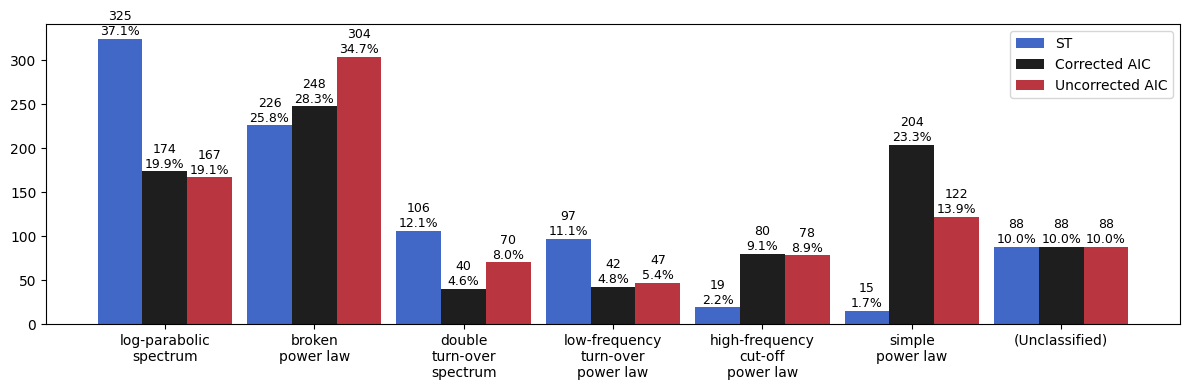

In [3]:
def best_fitting_classification(r_st, r_aic, r_aw):
    print('Best-fitting classification by the 3 methods:')
    
    def model_name_cap(model_name: str | np.ndarray):
        if isinstance(model_name, np.ndarray):
            return np.array([model_name_cap(m) for m in model_name])
        return model_name.replace('_', ' ').replace('g ', 'g-').replace(' f', '-f').replace(' o', '-o')
    def model_name_br(model_name: str | np.ndarray):
        if isinstance(model_name, np.ndarray):
            return np.array([model_name_br(m) for m in model_name])
        return model_name_cap(model_name).replace(' ', '\n').replace('r\nl', 'r l')
    
    total = len(r_st)
    
    x_st = r_st['best_fitting'].value_counts().index.to_numpy()
    y_st = r_st['best_fitting'].value_counts().to_numpy()
    x_aic = r_aic['best_fitting'].value_counts().index.to_numpy()
    y_aic = r_aic['best_fitting'].value_counts().to_numpy()
    x_aw = r_aw['best_fitting'].value_counts().index.to_numpy()
    y_aw = r_aw['best_fitting'].value_counts().to_numpy()
    
    # move unclassified to the end
    idx = np.where(x_st == '(Unclassified)')[0][0]
    x_st = np.concatenate([x_st[:idx], x_st[idx+1:], [x_st[idx]]])
    y_st = np.concatenate([y_st[:idx], y_st[idx+1:], [y_st[idx]]])
    
    # sort by x_st
    x_aic, y_aic = zip(*sorted(zip(x_aic, y_aic), key=lambda x: x_st.tolist().index(x[0])))
    x_aw, y_aw = zip(*sorted(zip(x_aw, y_aw), key=lambda x: x_st.tolist().index(x[0])))
    
    display(pd.DataFrame({
        'Model': model_name_cap(x_st),
        'Bayesian': [f'{v} / {total} ({v/total*100:.1f}%)' for v in y_st],
        'Corrected AIC': [f'{v} / {total} ({v/total*100:.1f}%)' for v in y_aic],
        'Uncorrected AIC': [f'{v} / {total} ({v/total*100:.1f}%)' for v in y_aw]
    }))
    
    fig, ax = plt.subplots(figsize=(12, 4))
    
    bar_width = 0.3
    bar_positions = np.arange(len(x_st))
    
    colors = sns.color_palette('icefire', 3)
    ax.bar(bar_positions - bar_width * 1.0, y_st, bar_width, label='ST', color=colors[0])
    ax.bar(bar_positions + bar_width * 0.0, y_aic, bar_width, label='Corrected AIC', color=colors[1])
    ax.bar(bar_positions + bar_width * 1.0, y_aw, bar_width, label='Uncorrected AIC', color=colors[2])
    labels_st = [f'{v}\n{v/total*100:.1f}%' for v in y_st]
    labels_aic = [f'{v}\n{v/total*100:.1f}%' for v in y_aic]
    labels_aw = [f'{v}\n{v/total*100:.1f}%' for v in y_aw]
    for i, (label_st, label_aic, label_aw) in enumerate(zip(labels_st, labels_aic, labels_aw)):
        ax.text(i - bar_width * 1.0, y_st[i] + 1, label_st, ha='center', va='bottom', fontsize=9)
        ax.text(i + bar_width * 0.0, y_aic[i] + 1, label_aic, ha='center', va='bottom', fontsize=9)
        ax.text(i + bar_width * 1.0, y_aw[i] + 1, label_aw, ha='center', va='bottom', fontsize=9)
    
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(model_name_br(x_st))
    ax.legend()
    plt.tight_layout()
    plt.show()
    
best_fitting_classification(results_st, results_aic, results_aw)

In [4]:
def ln_bayes_factors_greater_than_five(r):
    print('Ln Bayes factors greater than 5 (versus simple power law):')
    
    total = len(r)
    r = r[r['best_fitting'] != '(Unclassified)']  # Remove unclassified pulsars
    r_bf = r.drop(columns='best_fitting').sub(r['simple_power_law'], axis=0).drop(columns='simple_power_law')
    
    r_bf_gt5 = pd.DataFrame({
        'Bayesian': (r_bf > 5).sum(),
    })
    r_bf_gt5 = r_bf_gt5.loc[r_bf_gt5['Bayesian'].sort_values(ascending=False).index]
    
    r_bf_gt5.loc['(Any ln BF > 5)'] = [
        (r_bf > 5).any(axis=1).sum(),
    ]
    r_bf_gt5.loc['(All ln BF < -5)'] = [
        (r_bf < -5).all(axis=1).sum(),
    ]
    
    # change the values to {} / {} = {}% format
    r_bf_gt5 = r_bf_gt5.applymap(lambda x: f'{x:d} / {total} ({x/total*100:.1f}%)')
    
    display(r_bf_gt5)
    
ln_bayes_factors_greater_than_five(results_st)

Ln Bayes factors greater than 5 (versus simple power law):


,Bayesian
log_parabolic_spectrum,550 / 876 (62.8%)
broken_power_law,437 / 876 (49.9%)
low_frequency_turn_over_power_law,393 / 876 (44.9%)
double_turn_over_spectrum,382 / 876 (43.6%)
high_frequency_cut_off_power_law,279 / 876 (31.8%)
(Any ln BF > 5),604 / 876 (68.9%)
(All ln BF < -5),0 / 876 (0.0%)


In [5]:
SHOW_PLOTS = False
if SHOW_PLOTS:
    def get_plots(jname: str, models: list) -> bool:
        images = []
        outdirs = [outdir_st, outdir_aic]
        for i, outdir in enumerate(outdirs):
            file_path = f'../output/{outdir}/{jname}/{models[i]}_result.png'
            if not os.path.exists(file_path):
                continue
            images.append(Image.open(file_path))
        if len(images) < 2:
            return False
        else:
            Image.fromarray(np.hstack([np.array(image) for image in images])).show()
            return True
            
    aic_comp = results_aic[results_aic['best_fitting'] != '(Unclassified)'].drop(columns='best_fitting').sub(results_aic['simple_power_law'], axis=0).drop(columns='simple_power_law')
    aic_comp = aic_comp.dropna(how='all')
    aic_comp = aic_comp.loc[aic_comp.max(axis=1).sort_values(ascending=True).index]
    
    # add a column for corresponding best_fitting in results_st
    aic_comp['best_fitting'] = results_st.loc[aic_comp.index, 'best_fitting']
    
    cnt = 0
    id = 0
    while cnt < 5:
        ret = get_plots(aic_comp.index[id], [aic_comp['best_fitting'][id], 'simple_power_law'])
        id += 1
        if ret:
            cnt += 1

Number of MSPs in the catalogue: 178 / 2299 (7.7%)
Number of MSPs in the catalogue with fitting results: 85 / 876 (9.7%)
Best-fitting classification by the 3 methods:


,Model,Bayesian,Corrected AIC,Uncorrected AIC
0,log-parabolic spectrum,33 / 85 (38.8%),21 / 85 (24.7%),23 / 85 (27.1%)
1,broken power law,25 / 85 (29.4%),22 / 85 (25.9%),28 / 85 (32.9%)
2,low-frequency turn-over power law,11 / 85 (12.9%),3 / 85 (3.5%),4 / 85 (4.7%)
3,simple power law,5 / 85 (5.9%),26 / 85 (30.6%),14 / 85 (16.5%)
4,double turn-over spectrum,4 / 85 (4.7%),1 / 85 (1.2%),4 / 85 (4.7%)
5,high-frequency cut-off power law,2 / 85 (2.4%),7 / 85 (8.2%),7 / 85 (8.2%)
6,(Unclassified),5 / 85 (5.9%),5 / 85 (5.9%),5 / 85 (5.9%)


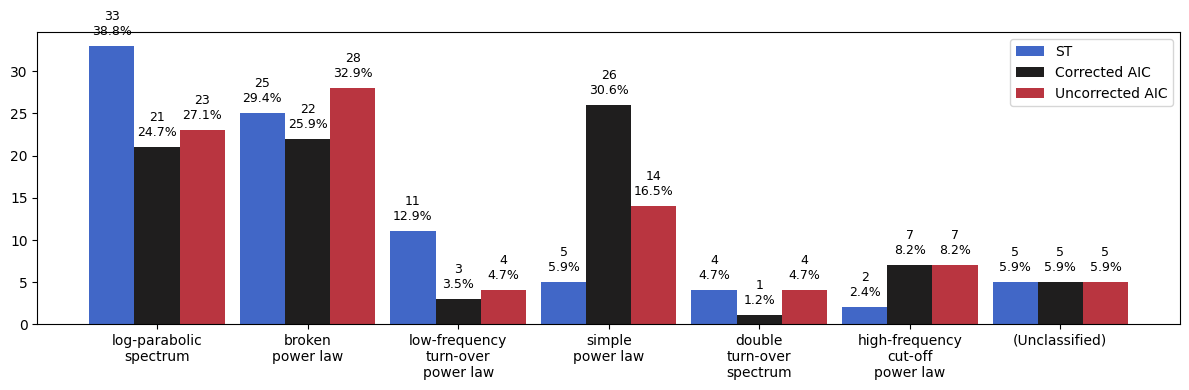

Ln Bayes factors greater than 5 (versus simple power law):


,Bayesian
log_parabolic_spectrum,54 / 85 (63.5%)
broken_power_law,45 / 85 (52.9%)
low_frequency_turn_over_power_law,37 / 85 (43.5%)
double_turn_over_spectrum,36 / 85 (42.4%)
high_frequency_cut_off_power_law,28 / 85 (32.9%)
(Any ln BF > 5),55 / 85 (64.7%)
(All ln BF < -5),0 / 85 (0.0%)


Best-fitting classification by the 3 methods:


,Model,Bayesian,Corrected AIC,Uncorrected AIC
0,log-parabolic spectrum,292 / 791 (36.9%),153 / 791 (19.3%),144 / 791 (18.2%)
1,broken power law,201 / 791 (25.4%),226 / 791 (28.6%),276 / 791 (34.9%)
2,double turn-over spectrum,102 / 791 (12.9%),39 / 791 (4.9%),66 / 791 (8.3%)
3,low-frequency turn-over power law,86 / 791 (10.9%),39 / 791 (4.9%),43 / 791 (5.4%)
4,high-frequency cut-off power law,17 / 791 (2.1%),73 / 791 (9.2%),71 / 791 (9.0%)
5,simple power law,10 / 791 (1.3%),178 / 791 (22.5%),108 / 791 (13.7%)
6,(Unclassified),83 / 791 (10.5%),83 / 791 (10.5%),83 / 791 (10.5%)


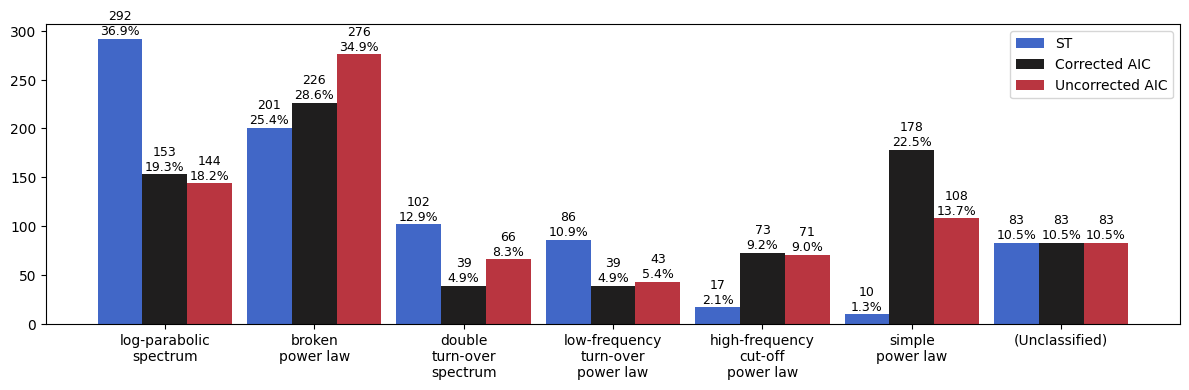

Ln Bayes factors greater than 5 (versus simple power law):


,Bayesian
log_parabolic_spectrum,496 / 791 (62.7%)
broken_power_law,392 / 791 (49.6%)
low_frequency_turn_over_power_law,356 / 791 (45.0%)
double_turn_over_spectrum,346 / 791 (43.7%)
high_frequency_cut_off_power_law,251 / 791 (31.7%)
(Any ln BF > 5),549 / 791 (69.4%)
(All ln BF < -5),0 / 791 (0.0%)


In [6]:
msp_list = catalogue.MSPs
print(f'Number of MSPs in the catalogue: {len(msp_list)} / {len(catalogue)} ({len(msp_list)/len(catalogue)*100:.1f}%)')
# Remove MSPs not in the results
msp_list = [msp for msp in msp_list if msp in results_st.index]
print(f'Number of MSPs in the catalogue with fitting results: {len(msp_list)} / {len(results_st.index)} ({len(msp_list)/len(results_st.index)*100:.1f}%)')

results_st_msp = results_st.loc[msp_list]
results_aic_msp = results_aic.loc[msp_list]
results_aw_msp = results_aw.loc[msp_list]

best_fitting_classification(results_st_msp, results_aic_msp, results_aw_msp)
ln_bayes_factors_greater_than_five(results_st_msp)

results_st_not_msp = results_st.loc[~results_st.index.isin(msp_list)]
results_aic_not_msp = results_aic.loc[~results_aic.index.isin(msp_list)]
results_aw_not_msp = results_aw.loc[~results_aw.index.isin(msp_list)]

best_fitting_classification(results_st_not_msp, results_aic_not_msp, results_aw_not_msp)
ln_bayes_factors_greater_than_five(results_st_not_msp)